# Upload a local dataset to DAT CORE
## SPARC data meeting
### December 5, 2018

### by: Max Novelli (man8@pitt.edu) RNEL, University of Pittsburgh

The first thing you do in python, is to import all the libraries needed in your script.  
For our purposes, the most important one is the library that allow us to connect to DAT CORE
```python
from blackfynn import Blackfynn
```

Import all the libraries that I need

In [1]:
import os
from blackfynn import Blackfynn
from blackfynn.models import Collection,DataPackage
import pprint
pp = pprint.PrettyPrinter()
from IPython.display import Image

Import library notebook

In [2]:
%run SPARC_201812_library.ipynb

In [3]:
DATCORE_DATASET, DATASET_PATH

('SPARC December 2018 Presentation',
 '/home/nitrosx/Documents/RNEL/Presentations/SPARC.20181205/notebooks/../SPARC_local_test_dataset')

Let's verify where the local test dataset is located

In [4]:
DATASET_PATH

'/home/nitrosx/Documents/RNEL/Presentations/SPARC.20181205/notebooks/../SPARC_local_test_dataset'

Let's explore the content of our local test dataset

In [5]:
prettyShowFolderTree(DATASET_PATH)

SPARC_local_test_dataset/
    dataset.json
    subject_3/
        subject3.json
        subject3.csv
        subject3.jpg
        subject3.bfts
    subject_2/
        subject2.bfts
        subject2.json
        subject2.jpg
        subject2.csv
    subject_1/
        subject1.jpg
        subject1.bfts
        subject1.json
        subject1.csv


Before we continue, we need to define few **concepts** that are necesseray to understand how DAT CORE works

- folders
    - DAT CORE : collections
    - action : create

- files
    - DAT CORE: dataPackages which contains the files uploaded
    - action: upload

First thing we build a list with all the elements in our dataset that needs to be created/uploaded to DAT CORE.

We are going to accomplish the task by defining a recursive function named  
```python
elements = buildUploadElementsList(DATASET_PATH)
```
which traverse the dataset and returns the list of what we need to upload.


In [6]:
def buildUploadElementsList(path,parent=None,level=0):
    actions = []
    for item in os.listdir(path):
        fullpath = os.path.join(path,item)
        if os.path.isfile(fullpath):
            actions.append({
                'element' : 'file',
                'action' : 'upload',
                'file' : item,
                'fullpath' : fullpath,
                'parent' : parent,
                'level' : level
            })
        elif os.path.isdir(fullpath):
            actions.append({
                'element' : 'collection',
                'action' : 'create',
                'collection' : item,
                'parent' : parent,
                'level' : level,
                'children' : buildUploadElementsList(
                    os.path.join(path,item),
                    item,
                    level+1)})
    return actions

In [7]:
elements = buildUploadElementsList(DATASET_PATH)
pp.pprint(elements)

[{'action': 'create',
  'children': [{'action': 'upload',
                'element': 'file',
                'file': 'subject3.json',
                'fullpath': '/home/nitrosx/Documents/RNEL/Presentations/SPARC.20181205/notebooks/../SPARC_local_test_dataset/subject_3/subject3.json',
                'level': 1,
                'parent': 'subject_3'},
               {'action': 'upload',
                'element': 'file',
                'file': 'subject3.csv',
                'fullpath': '/home/nitrosx/Documents/RNEL/Presentations/SPARC.20181205/notebooks/../SPARC_local_test_dataset/subject_3/subject3.csv',
                'level': 1,
                'parent': 'subject_3'},
               {'action': 'upload',
                'element': 'file',
                'file': 'subject3.jpg',
                'fullpath': '/home/nitrosx/Documents/RNEL/Presentations/SPARC.20181205/notebooks/../SPARC_local_test_dataset/subject_3/subject3.jpg',
                'level': 1,
                'parent': 'su

Let's define a function that prints nicely the list of elements

In [8]:
def prettyShowUploadElementsList(elements,level=0):
    for element in elements:
        print(
            '{:s} {:s} {:s} {:s}'.format(
                ' '*PRETTY_INDENTATION*level,
                element['action'],
                element['element'],
                element['collection' if element['element'] == 'collection' else 'file']))
        if element['element'] == 'collection' and 'children' in element.keys() and len(element['children']) > 0:
            prettyShowUploadElementsList(element['children'],level+1)
        

Here is what we obtain when we run the _buildUploadElementsList_ function previously defined on our dataset.

In [9]:
prettyShowUploadElementsList(elements)

 create collection subject_3
     upload file subject3.json
     upload file subject3.csv
     upload file subject3.jpg
     upload file subject3.bfts
 create collection subject_2
     upload file subject2.bfts
     upload file subject2.json
     upload file subject2.jpg
     upload file subject2.csv
 create collection subject_1
     upload file subject1.jpg
     upload file subject1.bfts
     upload file subject1.json
     upload file subject1.csv
 upload file dataset.json


#### Now we are ready to populate our dataset on DAT CORE

Let's instantiate the DAT CORE environment

In [10]:
dcInstance = Blackfynn()

We create or get our dataset

In [11]:
if DATCORE_DATASET in [item.name for item in dcInstance.datasets()]:
    dcDataset = dcInstance.get_dataset(DATCORE_DATASET)
else:
    dcDataset = dcInstance.create_dataset(DATCORE_DATASET)
dcDataset

<Dataset name='SPARC December 2018 Presentation' id='N:dataset:586237f2-46c6-47a1-ada4-ae06ca62e6e2'>

In order to perform the upload,  
we create the **function** _datcoreUploadElements_ which runs through the list **elements**  
and create collections (folders) and upload files, which are than presented as dataPackages

In [12]:
def datcoreUploadElements(elements,hPC):
    '''
    input:
     - actions: list of all the actions to be performed on Blackfynn, organized in a hierarchical list
     - hPC: dat core parent container where we should take action in
    '''
    # loop on all the actions
    for item in elements:
        # provide visual feedback to user
        print('Action : {:10s}, Parent: {:50s}'.format(item['action'],hPC.name),end='')
        # act on the action
        if item['element'] == 'collection':
            # here we address collection creation
            print('Collection : {:20s}'.format(item['collection']))
            # create collection on bf
            hC = hPC.create_collection(item['collection'])
            # save handle
            item['bfObject'] = hC
            # if there are children, descend in to the children list
            if 'children' in item.keys() and len(item['children']) > 0:
                datcoreUploadElements(item['children'],hC)
        elif item['element'] == 'file':
            # here we address file uploading
            print('File : {:20s}'.format(item['file']))
            # upload file
            res = hPC.upload(item['fullpath'])
            # save upload results
            item['bfResults'] = res
            

Now, we are really ready to upload...  
Let's run the function and do the upload

In [13]:
datcoreUploadElements(elements,dcDataset)

Action : create    , Parent: SPARC December 2018 Presentation                  Collection : subject_3           
Action : upload    , Parent: subject_3                                         File : subject3.json       
Action : upload    , Parent: subject_3                                         File : subject3.csv        
Action : upload    , Parent: subject_3                                         File : subject3.jpg        
Action : upload    , Parent: subject_3                                         File : subject3.bfts       
Action : create    , Parent: SPARC December 2018 Presentation                  Collection : subject_2           
Action : upload    , Parent: subject_2                                         File : subject2.bfts       
Action : upload    , Parent: subject_2                                         File : subject2.json       
Action : upload    , Parent: subject_2                                         File : subject2.jpg        
Action : upload    , Pare

Now we do some error checking.  
Let's print them nicely and check the results

<!-- The function _datcoreUploadElements_ returns results of every action performed  -->

In [20]:
def prettyShowUploadResults(elements,level=0):
    for element in elements:
        print(
            '{:40s} -> {:s}'.format(
                ' '.join([
                    element['action'],
                    element['element'],
                    element['collection' if element['element'] == 'collection' else 'file']]),
                element['bfObject'].id \
                    if element['element'] == 'collection' \
                    else element['bfResults'][0][0]['manifest']['content']['packageNodeId']))
        if element['element'] == 'collection' and 'children' in element.keys() and len(element['children']) > 0:
            prettyShowUploadResults(element['children'],level+1)

In [15]:
prettyShowUploadResults(elements)

create collection subject_3              -> N:collection:e308a053-874b-4657-a99b-f42b52385844
upload file subject3.json                -> N:package:67965622-58ec-44df-9be8-527d2a45b2c4
upload file subject3.csv                 -> N:package:2e28f252-2789-4092-86fb-f955382c88e5
upload file subject3.jpg                 -> N:package:344483ea-7e64-4d8f-ba13-7b35652cf920
upload file subject3.bfts                -> N:package:68df3ab4-c895-464e-951b-cbd237407362
create collection subject_2              -> N:collection:e13e45af-6773-4b90-9ec7-e7a97b309ac8
upload file subject2.bfts                -> N:package:a63b8e1e-82fa-455f-ae97-a2cd7604e25a
upload file subject2.json                -> N:package:75d6dc58-10ac-43d1-8d15-8e89e835cdda
upload file subject2.jpg                 -> N:package:8be9e929-27bc-4441-84e1-d03e41ab1c87
upload file subject2.csv                 -> N:package:46601b4c-be42-4d4a-a375-7cce21d67dcb
create collection subject_1              -> N:collection:5667a14f-8e89-4436-8d51-c5c

### Everything looks good.   
Every element has been created and it has been assigned an id from DAT CORE

Now let's check directly on DAT CORE

In [16]:
dcDataset.update()

In [17]:
prettyShowDatCoreDatasetFiles(dcDataset)

--------------------------------------------
DAT CORE
Dataset : SPARC December 2018 Presentation
Collections(Folders) and DataPackages(Files)
--------------------------------------------
    DataPackage = dataset.json
        File       = dataset (dataset.json)
    Collection = subject_1
        DataPackage = subject1.jpeg
            File       = subject1 (subject1.jpg)
        DataPackage = subject1.json
            File       = subject1 (subject1.json)
        DataPackage = subject1.bfts
            File       = subject1 (subject1.bfts)
        DataPackage = subject1.csv
            File       = subject1 (subject1.csv)
    Collection = subject_2
        DataPackage = subject2.json
            File       = subject2 (subject2.json)
        DataPackage = subject2.jpeg
            File       = subject2 (subject2.jpg)
        DataPackage = subject2.bfts
            File       = subject2 (subject2.bfts)
        DataPackage = subject2.csv
            File       = subject2 (subject2.csv)
  

Let's verify on DAT CORE web interface...  
Dataset top level:

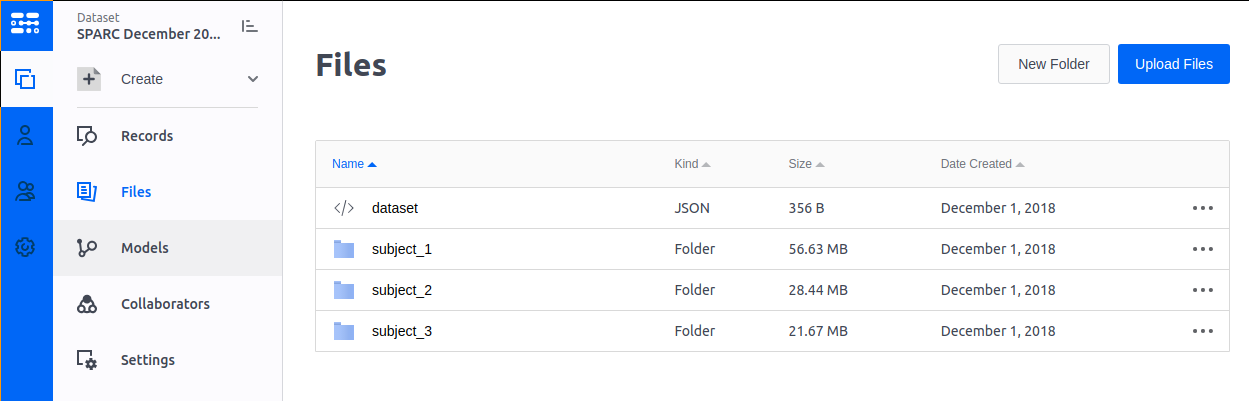

In [18]:
Image(filename='../images/dataset_files_uploaded_1.png')

Folder for subject 1:

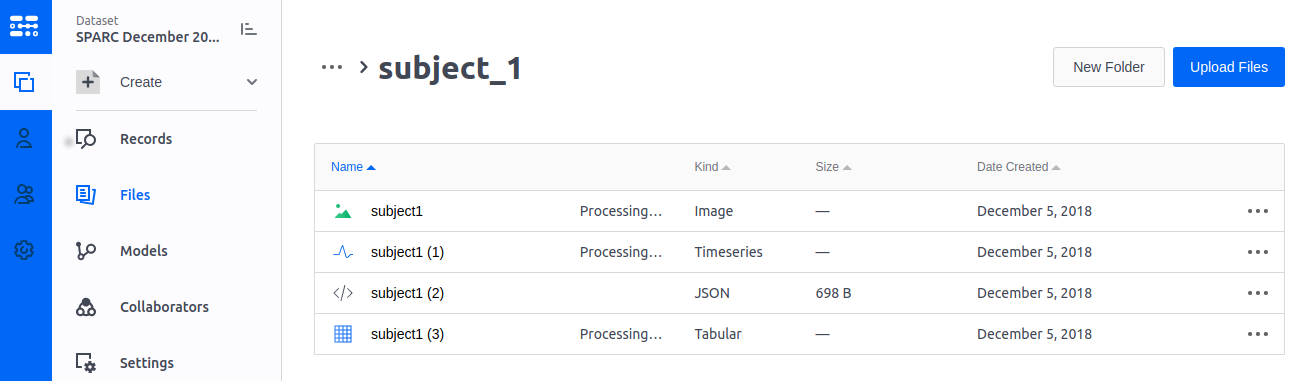

In [19]:
Image(filename='../images/dataset_files_uploaded_2.png')

## Congratulation!!! Test dataset uploaded.

## Thank you.
If you have any question, please come and find me during breaks.  
This notebook will be available to you through the SPARC material.  
Max Novelli (man8@pitt)